# Scaling monosemanticity

In [1]:
# Required installations for transformers and datasets
!pip install transformers datasets
!pip install keras huggingface_hub
!pip install tensorflow
!pip install python-dotenv
!pip install zstandard
#!pip install bitsandbytes

In [1]:
import os
import time
from dotenv import load_dotenv
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from huggingface_hub import login
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from transformers import BitsAndBytesConfig

2024-12-05 10:43:00.353106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733391780.367226   30077 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733391780.371353   30077 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 10:43:00.386642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Transformer activations - LLaMA 3.2 3B

In [3]:
load_dotenv()
hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/drew99/.cache/huggingface/token
Login successful


In [4]:

# # Hugging Face Login (get token from os environment)
# login(os.getenv("HF_ACCESS_TOKEN"))

# notebook_login()


# Could also later use 
# tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)

In [5]:

# Load the LLaMA 3.2B model without quantization (for now)
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device) # 16-bit precision

# Some other LLaMA models to try:
# https://huggingface.co/meta-llama/Llama-3.2-3B"
# https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct-QLORA_INT4_EO8
# https://huggingface.co/mradermacher/Fireball-Meta-Llama-3.2-8B-Instruct-agent-003-128k-code-DPO-i1-GGUF  i1-Q4_K_M
# https://huggingface.co/TheBloke/Llama-2-7B-Chat-GPTQ

# Prepare 4-bit quantization configuration (optional)
# Uncomment the following lines if you wish to use quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You shouldn't move a model that is dispatched using accelerate hooks.


In [6]:
print(model.model.layers) # Specific to LLaMA model # https://huggingface.co/docs/transformers/main/model_doc/llama#transformers.LlamaForCausalLM

ModuleList(
  (0): LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
      (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
      (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
      (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
      (rotary_emb): LlamaRotaryEmbedding()
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
      (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
      (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
  )
  (1): LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
      (k_proj): Linear4bit(in_f

In [7]:
activation_cache = []
def save_activations_hook(module, input, output):
    # input is a tuple; input[0] is the tensor we need
    activation_cache.append(input[0].cpu().detach().numpy())

# Register hook on the 16th layer
layer_index = 15  # Zero-based index; 15 corresponds to the 16th layer
hook_handle = model.model.layers[layer_index].register_forward_hook(save_activations_hook) 
# for other models, you may need to use model.transformer.h[15] instead of model.model.layers[15]


In [8]:

# Example input
input_text = "Your input text here."
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

# Access the residual stream activation
residual_stream = activation_cache[0]
print(f"Residual stream shape at layer {layer_index+1}: {residual_stream.shape}")

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Residual stream shape at layer 16: (1, 6, 3072)


In [ ]:
# Load the first 30 million examples from 'The Pile' dataset 
# https://huggingface.co/docs/datasets/loading#slice-splits
# data_len = 30_000_000
data_len = 30_000
# split_str = f"train[:{data_len}]"
dataset = load_dataset("monology/pile-uncopyrighted", split="train", streaming=True)

# Set up processing parameters
os.makedirs("activations_data", exist_ok=True)

# Initialize accumulators and parameters
batch_size = 8 # number of sentences in a batch
file_size = 10*8192 # number of examples in a file
files_saved = 0
batch_texts = []
activation_cache = [] # cache of activations for a batch
all_data = np.empty((0, 3075), dtype=np.float16)  # 3072 + 3 (sent_idx, token_idx, token)

# Create batches from the dataset
print("Processing dataset and saving activations in batches...")
for i, example in enumerate(dataset):
    batch_texts.append(example['text'])
    
    if (i + 1) % batch_size == 0 or i + 1 >= data_len:
        # Process full batch or final partial batch
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            max_length=513, # 512 + 1 for <begin_of_text> token, which will be removed later
            padding="max_length",
        ).to(device)
        
        with torch.no_grad():
            model(**inputs)
        
        # Convert activation_cache to numpy array and reshape
        batch_activations = np.array(activation_cache)
        
        # Reshape batch_activations from (1, 8, 42, 3072) to (8*42, 3072)
        batch_activations = batch_activations.reshape(batch_activations.shape[1] * batch_activations.shape[2], -1)

        # Create sentence index array (sent_idx) and token index array (token_idx)
        # sent_idx = [1 1 1 1 1; 2 2 2 2 2; 3 3 3 3 3; ...]
        # token_idx = [1 2 3 4 5; 1 2 3 4 5; 1 2 3 4 5; ...]
        num_sentences, num_tokens = inputs['attention_mask'].shape # (8, 42)
        sent_idx = np.repeat(np.arange(1, num_sentences + 1), num_tokens).reshape(-1, 1)  # Shape: (8*42, 1)
        sent_idx = sent_idx + (i - batch_size) # offset by batch index
        token_idx = np.tile(np.arange(1, num_tokens + 1), num_sentences).reshape(-1, 1)    # Shape: (8*42, 1)
        token_idx = token_idx - 1 # offset by 1
        # also save tokens id from tokenizer
        tokens = inputs['input_ids'].cpu().numpy().reshape(-1, 1)
        tokens = tokens - 64000 # offset by 64000 to not overflow float16
                                # 128000 is the vocab size of Llama 3.2 3B, float16 is [-65504, 65504]
                
        # Stack activations, sent_idx, and token_idx
        batch_activations = np.hstack((batch_activations, sent_idx, token_idx, tokens)).astype(np.float16)
        # Remove rows where attention mask is 0
        attention_mask = inputs['attention_mask'].cpu().numpy().reshape(-1)
        # Remove <begin_of_text> token (token_idx = 0)
        attention_mask[np.where(token_idx == 0)] = 0
        batch_activations = batch_activations[attention_mask != 0]

        # Stack to all_data
        all_data = np.vstack((all_data, batch_activations))
        print(f"all_data shape: {all_data.shape}")

        # Save to file if file_size limit is reached
        if all_data.shape[0] >= file_size:
            data_to_save = all_data[:file_size, :]
            np.save(f"activations_data/activations_batch_{files_saved:04d}.npy", data_to_save)
            # data_saved = np.load(f"activations_data/activations_batch_{files_saved:04d}.npy")
            # print(f"Data saved: {np.array_equal(data_to_save[:,:-3], data_saved[:,:-3])}")
            files_saved += 1
            print(f"Saved file {files_saved} == {file_size*files_saved} examples")
            all_data = all_data[file_size:, :]  # Retain any remaining rows
            
        # Reset for next batch
        batch_texts = []
        activation_cache = []

    if i + 1 >= data_len:
        break

# Save any remaining data
if all_data.shape[0] > 0:
    np.save(f"activations_data/activations_batch_{files_saved:04d}.npy", all_data)
    del all_data

print("Finished processing and saving all batches")



In [10]:
# 14743 / 60 /60 # 4.095277 hours for 10mil
# 129*81920 + 53548 # total num of tokens 10621228
0.5 *130 # 65 GB for 10mil


65.0

In [36]:
import glob
act_files = glob.glob("activations_data/act*.npy")

for i, f in enumerate(act_files):
    # remove begin token from all npy files
    a = np.load(f)
    a = a[a[:, -2] != 0]
    np.save(f, a)

    f1 = f.replace("/activations", "/last3")
    b = np.load(f1)
    b = b[b[:, -2] != 0]
    np.save(f1, b)
    print(f"Processed {i+1}/{len(act_files)}")



Processed 1/130
Processed 2/130
Processed 3/130
Processed 4/130
Processed 5/130
Processed 6/130
Processed 7/130
Processed 8/130
Processed 9/130
Processed 10/130
Processed 11/130
Processed 12/130
Processed 13/130
Processed 14/130
Processed 15/130
Processed 16/130
Processed 17/130
Processed 18/130
Processed 19/130
Processed 20/130
Processed 21/130
Processed 22/130
Processed 23/130
Processed 24/130
Processed 25/130
Processed 26/130
Processed 27/130
Processed 28/130
Processed 29/130
Processed 30/130
Processed 31/130
Processed 32/130
Processed 33/130
Processed 34/130
Processed 35/130
Processed 36/130
Processed 37/130
Processed 38/130
Processed 39/130
Processed 40/130
Processed 41/130
Processed 42/130
Processed 43/130
Processed 44/130
Processed 45/130
Processed 46/130
Processed 47/130
Processed 48/130
Processed 49/130
Processed 50/130
Processed 51/130
Processed 52/130
Processed 53/130
Processed 54/130
Processed 55/130
Processed 56/130
Processed 57/130
Processed 58/130
Processed 59/130
Proces

In [ ]:

# Unregister hook
hook_handle.remove()
# Shutdown the model use del and free gpu
del model
del tokenizer
torch.cuda.empty_cache()
print("Model deleted and GPU memory freed")


In [12]:
brek here

SyntaxError: invalid syntax (3466077266.py, line 1)

## Sparse autoencoder

In [18]:
activations = np.load("activations_data/activations_batch_0000.npy")

In [19]:
activations.shape # of float16 = 2 bytes per element

(81920, 3075)

In [20]:
# activations type
activations.dtype

dtype('float16')

In [21]:
activations.nbytes / 1e9 # in GB

0.503808

In [2]:
# Calculate scale factor
import glob

data_dir = "activations_data"
 # Load all batches
all_batches = sorted(glob.glob(f"{data_dir}/activations_batch_*.npy"))

# Load and concatenate batches
total_norm_squared = 0
num_samples = 0
for f in all_batches:
    activations = np.load(f)
    activations = activations[:, :-3] # remove last 3 columns (sent_idx, token_idx, and token)
    activations = activations.astype(np.float32)
    # max_a, min_a = np.finfo(activations.dtype).max, np.finfo(activations.dtype).min
    # activations = np.nan_to_num(activations, nan=0, posinf=max_a, neginf=min_a) # replace inf with max/min float value
    total_norm_squared += np.sum(np.linalg.norm(activations, axis=1)**2)
    num_samples += activations.shape[0]
    print(total_norm_squared, num_samples)
mean_squared_norm = total_norm_squared / num_samples
scale_factor = np.sqrt(mean_squared_norm)
print(f"Scale factor: {scale_factor}")

# Save scale factor - empty txt with factor in filename
with open(f"{data_dir}/scale_factor_{scale_factor:.4f}.txt", "w") as f:
    f.write(f"{scale_factor}")


11623434.0 81688
23151360.0 163366
34777302.0 245054
46312032.0 326726
57830237.0 408416
69505953.0 490108
80956040.0 571802
92678321.0 653485
104193349.0 735170
115686836.0 816862
127271062.0 898559
138902768.0 980232
150540107.0 1061930
162015917.0 1143622
173477853.0 1225316
184995436.0 1307001
196678303.0 1388696
208342423.0 1470382
219898030.0 1552083
231472490.0 1633772
243074103.0 1715463
254650738.0 1797153
266142412.0 1878843
277837685.0 1960530
289499349.0 2042224
301109122.0 2123924
312616766.0 2205623
324093408.0 2287298
335626759.0 2368987
347126740.0 2450672
358621118.0 2532360
370053656.0 2614048
381674502.0 2695742
393177965.0 2777435
404740926.0 2859129
416166199.0 2940820
427781599.0 3022496
439357500.0 3104184
450888817.0 3185869
462395700.0 3267557
473922598.0 3349244
485484815.0 3430938
496970895.0 3512626
508561730.0 3594316
520055112.0 3676006
531655296.0 3757696
543204825.0 3839391
554666735.0 3921062
566287932.0 4002744
577835047.0 4084446
589332703.0 4166128
6

In [2]:
# scale_factor = 34.12206415510119 # at 1.6mil tokens
# scale_factor = 34.128712991170886 # at 10.6mil tokens
scale_factor = 11.888623072966611 # 10mil but with <begin> token removed

In [3]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Linear(input_dim, hidden_dim)
        # Decoder
        self.decoder = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        # encoded = torch.nn.LeakyReLU(0.01)(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded, encoded


In [4]:
from torch.utils.data import Dataset, DataLoader
class ActivationDataset(Dataset):
    def __init__(self, data_dir, batch_size, f_type, test_fraction=0.01, scale_factor=1.0, seed=42):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seed = seed

        if f_type in ["train", "test", "all"]:
            self.f_type = f_type
        else:
            raise ValueError("f_type must be 'train' or 'test' or 'all'")
        
        if not 0 <= test_fraction <= 1:
            raise ValueError("test_fraction must be between 0 and 1")
        self.test_fraction = test_fraction

        self.scale_factor = scale_factor
        self.file_names = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy') and f.startswith('activations_batch')])
        
        split_idx = int(len(self.file_names) * (1 - test_fraction))
        if f_type == "train":
            self.file_names = self.file_names[:split_idx]
        elif f_type == "test":
            self.file_names = self.file_names[split_idx:]
        else: # all
            pass

        print(f"Loaded {len(self.file_names)} batches for {f_type} set")

    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.file_names[idx])
        activations = np.load(file_path)
        if self.f_type == "all":
            sent_idx = activations[:, -3]
            token_idx = activations[:, -2] 
            token = activations[:, -1]
        # remove last 3 columns (sent_idx, token_idx, and token)
        activations = activations[:, :-3]
        # normalize activations
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        activations = torch.tensor(activations, dtype=torch.float32, device=device)
        # print("Activation Range Before Normalization:", torch.min(activations).item(), torch.max(activations).item())
        activations = activations / self.scale_factor * np.sqrt(activations.shape[1])
        # print("Activation Range After Normalization:", torch.min(activations).item(), torch.max(activations).item())

        if self.f_type == "train":
            # Set seed for reproducibility
            np.random.seed(self.seed)
            # random subsample 8192 examples
            indices = torch.randperm(activations.shape[0], device=activations.device)[:self.batch_size]
            activations = activations[indices]
        
        if self.f_type == "all":
            return activations, sent_idx, token_idx, token
        else:
            return activations



In [5]:
# Create dataset and dataloader
data_dir = "activations_data"
dataset = ActivationDataset(
    data_dir, 
    batch_size=2048, # 8192 examples per batch
    f_type="train", 
    test_fraction=0.01, 
    scale_factor=scale_factor, 
    seed=42
)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False) # take 1 batch at a time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model parameters
input_dim = 3072  
hidden_dim = 20000 # = 4096  # Adjust based on your requirements

# Initialize the model
model = SparseAutoencoder(input_dim, hidden_dim).to(device)

# Set up loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
l1_lambda = 0.01  # Regularization strength for sparsity

# Training loop
num_epochs = 8 # should be 1 

print(f"Training Parameters:\n"
      f"Data Directory: {data_dir}\n"
      f"Batch Size: {dataset.batch_size}\n"
      f"Test Fraction: {dataset.test_fraction}\n"
      f"Scale Factor: {scale_factor}\n"
      f"Seed: {dataset.seed}\n"
      f"Optimizer: {optimizer.__class__.__name__}\n"
      f"Learning Rate: {optimizer.param_groups[0]['lr']}\n"
      f"L1 Lambda: {l1_lambda}\n"
      f"Number of Epochs: {num_epochs}\n"
      f"SAE Input Dimension: {input_dim}\n"
      f"SAE Hidden Dimension: {hidden_dim}\n"
      f"-----------------------------------"
)
time_start = time.time()
for epoch in range(num_epochs):
    total_loss = 0
    # dataset.seed = epoch # change seed for each epoch to get different samples
    dataset.seed = epoch//4  # this effectively does: batch_size * 4 , and epoch / 4
    for i, batch in enumerate(data_loader):
        print("Batch number: ", i)
        # batch is already of shape (1, 8192, 3072)        
        # Forward pass
        batch = batch.to(device)
        outputs, encoded = model(batch) # remove extra dimension from DataLoader
        mse_loss = criterion(outputs, batch)

        # Active features calculation
        # Count how many latent features (columns) are active (nonzero for any token in the batch)
        active_features = torch.any(encoded > 0, dim=1).sum().item()
        total_features = encoded.shape[2]  # Number of latent features (4096 in this case)
        active_percentage = active_features / total_features * 100
        # print(f"Encoded Activation Range: {torch.min(encoded).item()}, {torch.max(encoded).item()}")
        print(f"Active Features: {active_percentage:.2f}%")

        # Add L1 regularization for sparsity
        # decoder_weight_norms = torch.norm(model.decoder.weight, 2, dim=0)
        # l1_loss = torch.norm(encoded, 1) * decoder_weight_norms.sum()
        # l1_loss = torch.sum(torch.norm(model.decoder.weight, 2, dim=0) * torch.norm(encoded, 1, dim=(0, 1)))
        decoder_weight_norms = torch.norm(model.decoder.weight, p=2, dim=0)  # Shape: [num_features]
        l1_terms = encoded * decoder_weight_norms.unsqueeze(0)  # Shape: [batch_size, num_features]
        l1_loss_per_sample = torch.sum(l1_terms, dim=1)  # Shape: [batch_size]
        l1_loss = torch.mean(l1_loss_per_sample)

        loss = mse_loss + l1_lambda * l1_loss

        print(f"Decoder Weight Norm (Mean): {torch.norm(model.decoder.weight, dim=0).mean().item()}")

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f"MSE Loss: {mse_loss.item():.4f}, L1 Loss: {l1_lambda}*{l1_loss.item():.4f}")
        # if mse_loss.item() < 0.1:
        #     optimizer.lr = 0.001

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f} ----------------------------")
time_end = time.time()
print(f"Time taken: {time_end - time_start:.2f} seconds")


Loaded 128 batches for train set
Training Parameters:
Data Directory: activations_data
Batch Size: 2048
Test Fraction: 0.01
Scale Factor: 11.888623072966611
Seed: 42
Optimizer: Adam
Learning Rate: 0.0001
L1 Lambda: 0.01
Number of Epochs: 8
SAE Input Dimension: 3072
SAE Hidden Dimension: 20000
-----------------------------------
Batch number:  0
Active Features: 100.00%
Decoder Weight Norm (Mean): 0.22624428570270538
MSE Loss: 1.0640, L1 Loss: 0.01*106.5588
Batch number:  1
Active Features: 100.00%
Decoder Weight Norm (Mean): 0.22564105689525604
MSE Loss: 1.0291, L1 Loss: 0.01*96.5958
Batch number:  2
Active Features: 100.00%
Decoder Weight Norm (Mean): 0.2249046117067337
MSE Loss: 0.9733, L1 Loss: 0.01*87.9923
Batch number:  3
Active Features: 100.00%
Decoder Weight Norm (Mean): 0.22413066029548645
MSE Loss: 0.9441, L1 Loss: 0.01*79.5778
Batch number:  4
Active Features: 100.00%
Decoder Weight Norm (Mean): 0.22330711781978607
MSE Loss: 0.9208, L1 Loss: 0.01*71.4463
Batch number:  5
Act

In [6]:
torch.sum(torch.norm(model.decoder.weight, 2, dim=0) * torch.norm(encoded, 1, dim=(0, 1)))

tensor(265305.7500, device='cuda:0', grad_fn=<SumBackward0>)

In [7]:
decoder_weight_norms = torch.norm(model.decoder.weight, 2, dim=0)
torch.norm(encoded, 1) * decoder_weight_norms.sum()

tensor(3.6911e+09, device='cuda:0', grad_fn=<MulBackward0>)

In [8]:
decoder_weight_norms = torch.norm(model.decoder.weight, p=2, dim=0)  # Shape: [num_features]

# Compute L1 loss
l1_terms = encoded * decoder_weight_norms.unsqueeze(0)  # Shape: [batch_size, num_features]
l1_loss_per_sample = torch.sum(l1_terms, dim=1)  # Shape: [batch_size]
l1_loss = torch.mean(l1_loss_per_sample)
l1_loss

tensor(13.2653, device='cuda:0', grad_fn=<MeanBackward0>)

In [9]:
nn.functional.mse_loss(outputs, batch)

tensor(0.3471, device='cuda:0', grad_fn=<MseLossBackward0>)

In [10]:
batch

tensor([[[ 0.5674, -0.0768,  0.6607,  ..., -0.2379, -0.5708,  0.4291],
         [ 0.1992, -1.6754, -0.8184,  ..., -0.6283, -0.5145,  0.9914],
         [-0.3335, -0.3261, -3.3714,  ..., -0.3588, -0.4223, -1.9554],
         ...,
         [-0.5190, -0.0219, -1.9429,  ..., -0.2146, -0.3944, -1.6162],
         [-0.1195, -1.0984,  0.1002,  ..., -0.5987, -0.2709, -0.4835],
         [ 0.6391, -0.0174, -1.4922,  ..., -2.1341, -0.9686,  0.6579]]],
       device='cuda:0')

In [11]:
for i, e in enumerate(encoded[0][0].tolist()):
    if e > 0:
        print(i, end=" ")


149 174 394 465 594 595 676 686 889 959 1118 1178 1192 1279 1294 1386 1473 1491 1544 1592 1665 1831 1842 1882 1924 2052 2293 2303 2390 2508 2547 2566 2587 2703 2724 2826 2831 2877 2960 2996 3063 3100 3243 3320 3517 3585 3672 3731 3760 3792 4159 4186 4258 4294 4311 4363 4592 4812 4895 4911 4925 4955 5074 5146 5392 5591 5749 6032 6059 6373 6400 6513 6785 6831 7016 7149 7416 7546 7608 7614 7741 7818 7848 7856 7863 7869 7996 8045 8078 8122 8305 8371 8379 8521 8551 8627 8634 8641 8666 8681 8872 8873 8987 9076 9148 9268 9286 9370 9649 9741 9776 9787 9823 9854 9919 9937 10082 10791 10831 11048 11431 11576 11715 11745 11766 11879 11918 11924 11981 12305 12365 12438 12450 12513 12530 12538 12552 12577 12771 12776 12951 12961 13261 13341 13499 13643 13693 13694 13720 13822 14040 14085 14089 14139 14202 14333 14374 14395 14457 14582 14858 14963 15084 15156 15407 15544 15610 15623 15636 15696 15753 15951 16006 16013 16458 16507 16566 16644 16857 16955 16975 17085 17342 17375 17436 17642 17675 1775

In [12]:
outputs

tensor([[[ 2.7803e-01, -3.0534e-01,  7.9855e-01,  ..., -2.0366e-01,
          -1.1266e+00,  2.1898e-01],
         [ 1.5722e-02, -1.0040e+00, -4.0356e-01,  ..., -8.4667e-01,
           2.6732e-01,  3.1934e-01],
         [ 1.6639e-01, -5.1605e-01, -1.8754e+00,  ..., -1.4928e-01,
          -3.2643e-01, -5.0592e-01],
         ...,
         [-1.7158e-01,  2.4333e-01, -2.4313e+00,  ..., -4.6648e-01,
          -8.6239e-01, -7.5687e-01],
         [-1.6957e-01, -3.8168e-01,  6.1277e-04,  ..., -7.5876e-01,
          -4.5029e-01, -5.1025e-02],
         [ 4.9176e-01, -6.6356e-01, -1.0524e+00,  ..., -9.8739e-01,
          -1.2001e+00,  5.3279e-01]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [13]:
criterion(outputs,batch)

tensor(0.3471, device='cuda:0', grad_fn=<MseLossBackward0>)

In [16]:
# save model
torch.save(model.state_dict(), f"models/sparse_autoencoder_tmp.pth")

In [11]:
# clear gpu
del model
del data_loader
del dataset
del criterion
del optimizer
del batch
import gc
gc.collect()
torch.cuda.empty_cache()
print("Model deleted and GPU memory freed")

Model deleted and GPU memory freed


### Test

In [5]:
data_dir = "activations_data"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = 3072  
hidden_dim = 65536


In [6]:
model = SparseAutoencoder(input_dim, hidden_dim).to(device)
# model.load_state_dict(torch.load("models/sparse_autoencoder_496.3666.pth"))
checkpoint = torch.load("models/checkpoint")
print(checkpoint["hyper_parameters"])
model.load_state_dict(checkpoint['state_dict'])

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
l1_lambda = 0.01  # Regularization strength for sparsity


/tmp/ipykernel_30077/1824788391.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("models/checkpoint")


{'input_dim': 3072, 'hidden_dim': 65536, 'l1_lambda': 0.00597965, 'lr': 2.5011e-05}


In [ ]:
# Test model
# test_dataset = ActivationDataset(
#     data_dir, 
#     batch_size=0, # not subsampled
#     f_type="test", 
#     # test_fraction=0.01, # last batch file
#     test_fraction=0.6, # 12 files == cca 10mil tokens
#     scale_factor=scale_factor, 
#     seed=42 # not used for test set
# ) # this outputs batches of size 81k  - too big for VRAM
test_dataset = ActivationDataset(
    data_dir, 
    batch_size=8,
    f_type="train", 
    # test_fraction=0.01, # last batch file
    test_fraction=0.0, # 12 files == cca 10mil tokens
    scale_factor=scale_factor, 
    seed=123 # different seed that in actual training
) # this outputs batches of size 49k - uses 7820MiB VRAM = 95% of GPU
data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) # take 1 batch at a time

# Set model to evaluation mode
model.eval()

# Run and compute reconstruction error, l1 loss, and total loss
total_loss = 0; total_mse_loss = 0; total_l1_loss = 0; num_batches = 0
global_active_mask = torch.zeros((hidden_dim), dtype=torch.bool, device=device)
for batch in data_loader:
    batch = batch.to(device)
    
    outputs, encoded = model(batch)

    # percent of active features
    # print(encoded.min().item(), encoded.max().item())
    global_active_mask |= torch.any(encoded > 0, dim=1).squeeze(0)
    active_features = torch.any(encoded != 0, dim=1).sum().item()  # Count active features
    total_features = encoded.shape[2]  # Total number of latent features (4096)
    percent_active_features = active_features / total_features
    print(f"Percent Active Features: {percent_active_features * 100:.2f}%")

    mse_loss = criterion(outputs, batch)
    decoder_weight_norms = torch.norm(model.decoder.weight, p=2, dim=0)  # Shape: [num_features]
    l1_terms = encoded * decoder_weight_norms.unsqueeze(0)  # Shape: [batch_size, num_features]
    l1_loss_per_sample = torch.sum(l1_terms, dim=1)  # Shape: [batch_size]
    l1_loss = torch.mean(l1_loss_per_sample)
    loss = mse_loss + l1_loss

    total_loss += loss.item()
    total_mse_loss += mse_loss.item()
    total_l1_loss += l1_loss.item()

    explained_variance = 1 - mse_loss / torch.var(batch)
    # Print batch-level metrics
    print(f"MSE Loss: {mse_loss.item():.4f}, L1 Loss: {l1_loss.item():.4f}, Explained Var: {explained_variance.item():.4f}")
    num_batches += 1


In [ ]:

# Print final metrics
print(f"Total Test Loss: {total_loss/num_batches:.4f}")
print(f"Total MSE Loss: {total_mse_loss/num_batches:.4f}")
print(f"Total L1 Loss: {total_l1_loss/num_batches:.4f}")

active_features = global_active_mask.sum().item()
total_features = global_active_mask.numel()
global_sparsity = (1 - active_features / total_features) * 100
print(f"Global Sparsity Across All Batches: {global_sparsity:.2f}%")
print(f"Percent of Active Features: {active_features / total_features * 100:.2f}%")


In [24]:
# save model
torch.save(model.state_dict(), f"models/sparse_autoencoder_{total_loss:.4f}.pth")

### Eval

In [ ]:
# Set model to evaluation mode
model.eval()
os.makedirs("sparse_latent_vectors", exist_ok=True)

dataset = ActivationDataset(
    data_dir, 
    batch_size=0, # not subsampled
    f_type="all", 
    test_fraction=1.0, # not used if type=all
    scale_factor=scale_factor, 
    seed=42 # not used
)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False) # take 1 batch at a time

# Extract and save latent vectors
batch_size = 8192  # Size we can fit in VRAM
num_minibatches = 10  # 81920/8192 = 10 minibatches per batch
with torch.no_grad():
    for idx, batch_data in enumerate(data_loader):
        batch, sent_idx, token_idx, token = batch_data
        sent_idx = sent_idx.to(device)
        token_idx = token_idx.to(device)
        token = token.to(device)
        batch = batch.squeeze(0)  # Remove batch dimension of 1
        
        # Process minibatches and save immediately
        for i in range(num_minibatches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            
            # Get minibatch slice
            minibatch = batch[start_idx:end_idx]
            _, encoded = model(minibatch)
            
            # Stack with metadata
            # Reshape metadata tensors to match batch size
            sent_idx_batch = sent_idx[:,start_idx:end_idx].T
            token_idx_batch = token_idx[:,start_idx:end_idx].T
            token_batch = token[:,start_idx:end_idx].T
            
            output_vectors = torch.cat((encoded, sent_idx_batch, token_idx_batch, token_batch), dim=1)
            
            # Save each minibatch immediately as a PyTorch tensor
            torch.save(output_vectors, f"sparse_latent_vectors/latent_vectors_batch_{idx}_minibatch_{i}.pt")
            # output_saved = torch.load(f"sparse_latent_vectors/latent_vectors_batch_{idx}_minibatch_{i}.pt")
            # output_vectors = output_vectors.to(torch.float16)
            # print(f"Data saved is near equal: {torch.allclose(output_vectors[:,:-3], output_saved[:,:-3], atol=1e-1)}")
            print(f"Saved minibatch {i+1} of {num_minibatches} for batch {idx}")



## Analysis of latent vectors

In [8]:

# Load and examine saved latent vectors
loaded_latent_vectors = np.load("sparse_latent_vectors/latent_vectors_batch_0.npy")
print(f"Loaded sparse latent vectors shape: {loaded_latent_vectors.shape}")
print(loaded_latent_vectors.dtype)
print(loaded_latent_vectors.nbytes / 1e9, "GB")
# Could potentially load 10k batches (0.0002048 GB per batch) if we keep latent vector size 512
# So for emb size 1M , we could load only 5 batches at a time

# Sparsity check
sparsity = np.mean(np.abs(loaded_latent_vectors[:,:-3]) < 1e-5)
print(f"Average sparsity in latent vectors: {sparsity:.2%}")

# Dead/active features check
# percent of columns that are all close to 0
dead_features = np.mean(np.all(np.abs(loaded_latent_vectors[:,:-3]) < 1e-5, axis=0))
print(f"Percent of dead features: {dead_features:.2%}")

# Reconstruction explained variance check
# mean of squared errors between original and reconstructed activations
# TODO: do this for all batches : loop data_loader
# mse = np.mean((loaded_latent_vectors - batch) ** 2)
# print(f"Mean squared error between original and reconstructed activations: {mse:.2%}")



Loaded sparse latent vectors shape: (81920, 4099)
float32
1.34316032 GB
Average sparsity in latent vectors: 99.98%
Percent of dead features: 89.89%


### Top activations

In [1]:
import glob
import numpy as np
import torch
from transformers import AutoTokenizer
from datasets import load_dataset

def load_latent_vectors(N):
    # Load first N batches
    batch_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.npy"))[:N]

    # Load and concatenate batches
    latent_vectors = []
    for batch_file in batch_files:
        batch_vectors = np.load(batch_file)
        latent_vectors.append(batch_vectors)
    latent_vectors = np.concatenate(latent_vectors, axis=0)

    print(f"Loaded {len(batch_files)} batches, total shape: {latent_vectors.shape}")
    return latent_vectors

latent_vectors = load_latent_vectors(N=5)


Loaded 5 batches, total shape: (409600, 4099)


In [2]:

feat_idx = 100
k = 20

# Get indices of top k activations for the specified feature
top_k_indices = np.argsort(latent_vectors[:, feat_idx])[-k:][::-1]
last_three_features = latent_vectors[top_k_indices, -3:]
top_values = latent_vectors[top_k_indices, feat_idx]

# Load tokenizer
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Loop through each row of last_two_features
print(f"Top {k} activations for feature {feat_idx}:")
for i, (sent_idx, tok_idx, token) in enumerate(last_three_features):
    sent_idx = int(sent_idx)
    tok_idx = int(tok_idx)
    token = int(token)
    # Find the row where sent_idx and tok_idx match in latent_vectors
    sent_matches = latent_vectors[:, -3] == sent_idx
    tok_matches = latent_vectors[:, -2] == tok_idx
    target_row = np.where(sent_matches & tok_matches)[0][0]
    
    # Get window of tokens from latent vectors
    start_idx = max(0, target_row - 20)
    end_idx = min(latent_vectors.shape[0], target_row + 20)
    # token_window = latent_vectors[start_idx:end_idx, -1].astype(int) # Get token ids from last column
    token_window = np.clip(latent_vectors[start_idx:end_idx, -1], 0, tokenizer.vocab_size - 1).astype(int)
    
    # Decode tokens back to text
    window_text = tokenizer.decode(token_window)
    print(f"\nSentence index: {sent_idx}")
    print(f"Token index: {tok_idx}")
    print(f"Value: {top_values[i]}")
    print(f"Context window: {window_text}")



Top 20 activations for feature 100:

Sentence index: 194
Token index: 481
Value: 0.03263506293296814
Context window:  also very important to diagonal_sb to know./a the rightiff of sing to choose toCount you from any possible af in diagonalometers.

If you lik sadd to ":" Brooklyn from your []( all the

Sentence index: 3028
Token index: 323
Value: 0.0
Context window: " dataencies
 "

 where you need more than a dictionary butstand than a class
Not combination to be use things like __ //#691ales the glass alla documentation:

 Agency alla may beChanged as

Sentence index: 389
Token index: 391
Value: 0.0
Context window: 오 + 1];
   garStringGetcopy8 Phaser(resultistoryRef, buffer, length + 1);
   garStringRelease(resultistoryRef);
    GRA->ente)];
);
  }
}


Sentence index: 389
Token index: 381
Value: 0.0
Context window: StringGetLength(resultistoryRef);
    char buffer오 + 1];
   garStringGetcopy8 Phaser(resultistoryRef, buffer, length + 1);
   garStringRelease(resultistoryRef

Sentence in

#### Show how much a feature activates on each word


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import pandas as pd
import numpy as np
from IPython.display import display

sentence = "The quick brown fox jumps over the lazy dog."
feat_idx = 100

# Load tokenizer and model
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)
activation_cache = []
def save_activations_hook(module, input, output):
    # input is a tuple; input[0] is the tensor we need
    activation_cache.append(input[0].cpu().detach().numpy())

# Register hook on the 16th layer
layer_index = 15  # Zero-based index; 15 corresponds to the 16th layer
hook_handle = model.model.layers[layer_index].register_forward_hook(save_activations_hook) 

# Tokenize sentence
inputs = tokenizer(
    sentence,
    return_tensors="pt",
    # truncation=True,
    # max_length=512,
    # padding="max_length",
).to(device)

# Forward pass
with torch.no_grad():
    model(**inputs)


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You shouldn't move a model that is dispatched using accelerate hooks.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
2024-11-20 00:05:18.472550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732057518.560527    5476 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732057518.587562    5476 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 00:05:18.812881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 

In [4]:
activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, 1, seq_len, 3072)
activations = activations.squeeze()  # Remove first two dimensions
activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor with float32 dtype


Activations shape: (1, 1, 11, 3072)


In [11]:


# Load sparse autoencoder
input_dim = 3072
hidden_dim = 2 ** 12
model = SparseAutoencoder(input_dim, hidden_dim)
model.load_state_dict(torch.load("sparse_autoencoder_2.5976.pth"))

# Get latent vector for sentence
with torch.no_grad():
    _, encoded = model(activations)
    latent_vector = encoded.cpu().numpy()

# Extract for feature X
feature_X = latent_vector[:, feat_idx]
# feature_X = np.random.rand(len(feature_X))

# Plot tokens colored by activation strength

# Create DataFrame with tokens and their activation values
tokens_list = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
# Remove the "Ġ" character from tokens - represents a space
clean_tokens_list = [token.replace('Ġ', '') for token in tokens_list]

df = pd.DataFrame({
    'Token': clean_tokens_list,
    'Activation': feature_X
})

# Display DataFrame with color gradient based on activation values
display(df.style.background_gradient("coolwarm"))


,Token,Activation
0,<|begin_of_text|>,0.200999
1,The,0.156023
2,quick,0.761146
3,brown,0.157970
4,fox,0.673777
5,jumps,0.249929
6,over,0.816395
7,the,0.597015
8,lazy,0.468434
9,dog,0.546607


### Influence LLM

In [ ]:
# Required libraries
import os
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

# Model and tokenizer setup
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=hf_token)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)

# Load the sparse autoencoder model and weights
input_dim = 3072  
hidden_dim = 2 ** 9
model_sae = SparseAutoencoder(input_dim, hidden_dim)
model_sae.load_state_dict(torch.load("sparse_autoencoder.pth"))
model_sae.eval()


In [21]:

# Generate artificial latent vector, pass through SAE decoder, and boost it
feat_idx = 100
artificial_latent_vector = np.zeros(3072)
artificial_latent_vector[feat_idx] = 1
multiplier = 10

with torch.no_grad():
    artificial_latent_vector_tensor = torch.tensor(artificial_latent_vector, dtype=torch.float32).unsqueeze(0)
    reconstructed_activations, _ = model_sae(artificial_latent_vector_tensor)
    boosted_activations = reconstructed_activations * multiplier

# Hook to inject boosted activations at a specified transformer layer
activation_cache = []
layer_index = 15  # Inject into the 16th layer

# Convert boosted_activations to float16 to match model precision
boosted_activations = boosted_activations.to(torch.float16)

# Hook function to inject boosted activations into the residual stream of the transformer layer
def influence_hook(module, input, output):
    # Ensure output is properly unpacked if it's a tuple
    if isinstance(output, tuple):
        output_tensor = output[0]
        modified_output = (output_tensor + boosted_activations.to(device),) + output[1:]
    else:
        modified_output = output + boosted_activations.to(device)
    
    activation_cache.append(modified_output[0].cpu().detach().numpy())  # Store modified tensor for debugging if needed
    return modified_output

# Register the hook with the corrected function
hook_handle = model.model.layers[layer_index].register_forward_hook(influence_hook)

# Prediction loop for N words
sent_begin = "I am a"
N = 10  # Number of words to predict
inputs = tokenizer(sent_begin, return_tensors="pt").to(device)
generated_text = sent_begin

for _ in range(N):
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_token_id = torch.argmax(outputs.logits[0, -1]).item()
        predicted_token = tokenizer.decode([predicted_token_id])
        generated_text += " " + predicted_token
        # Update inputs to include the predicted token for next iteration
        inputs = tokenizer(generated_text, return_tensors="pt").to(device)

# Remove hook and clear resources
hook_handle.remove()

print(f"Generated text with influence: '{generated_text}'")



Generated text with influence: 'I am a                    '


### Feature similarity and UMAP (plus feature splitting)


Loaded 10 batches, total shape: (788552, 512)


/home/drew99/IJS/LLMinfluence/venvllm/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


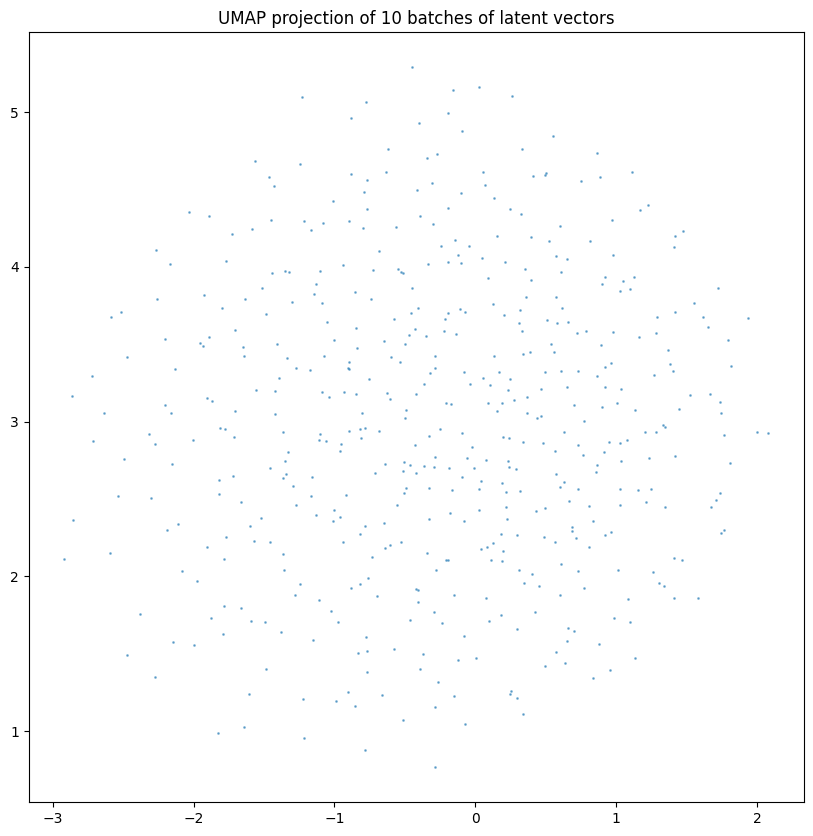

In [22]:
# umap-learn
# pip install umap-learn
import umap
import matplotlib.pyplot as plt
import glob

# Load first N batches
N = 10  # Number of batches to load
batch_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.npy"))[:N]

# Load and concatenate batches
latent_vectors = []
for batch_file in batch_files:
    batch_vectors = np.load(batch_file)
    latent_vectors.append(batch_vectors)
latent_vectors = np.concatenate(latent_vectors, axis=0)

# Remove last 3 columns (sent_idx, tok_idx, token)
latent_vectors = latent_vectors[:, :-3]

print(f"Loaded {len(batch_files)} batches, total shape: {latent_vectors.shape}")

# TODO: do a selection of features (feature of interest, and 100 similar features)

# UMAP dimensionality reduction
umap_embedder = umap.UMAP(n_components=2, metric='cosine')
latent_vectors_2d = umap_embedder.fit_transform(latent_vectors.T)

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], s=1, alpha=0.5)
plt.title(f'UMAP projection of {N} batches of latent vectors')
plt.show()

### Feature specificity

### Feature completness

## Feature search

### Single prompt search

In [25]:
activation_cache = []
def save_activations_hook(module, input, output):
    # input is a tuple; input[0] is the tensor we need
    activation_cache.append(input[0].cpu().detach().numpy())

# Register hook on the 16th layer
layer_index = 15  # Zero-based index; 15 corresponds to the 16th layer
hook_handle = model.model.layers[layer_index].register_forward_hook(save_activations_hook) 

In [30]:
prompt = "in San Francisco, the Golden Gate Bridge was protected at all times by a"

# Tokenize sentence
inputs = tokenizer(
    sentence,
    return_tensors="pt",
    # truncation=True,
    # max_length=512,
    # padding="max_length",
).to(device)

activation_cache = []
# Forward pass
with torch.no_grad():
    model(**inputs)

activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, 1, seq_len, 3072)
activations = activations.squeeze()  # Remove first two dimensions
activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor with float16 dtype

# Get latent vector for sentence
with torch.no_grad():
    _, encoded = model_sae(activations)
    latent_vector = encoded.cpu().numpy() # (seq_len, 1M)

# Apply row softmax normalization
row_softmax = torch.nn.functional.softmax(torch.tensor(latent_vector), dim=1).numpy()

# Sum over sequence length dimension to get feature importance across sentence
feature_importance = np.sum(row_softmax, axis=0)

# Get top 5 features and their values
top_k = 5
top_feature_indices = np.argsort(feature_importance)[-top_k:][::-1]
top_feature_values = feature_importance[top_feature_indices]

print("Top 5 features and their activation values:")
for idx, val in zip(top_feature_indices, top_feature_values):
    print(f"Feature {idx}: {val:.4f}")



Activations shape: (1, 1, 11, 3072)
Top 5 features and their activation values:
Feature 246: 0.2927
Feature 63: 0.2336
Feature 471: 0.1375
Feature 69: 0.1166
Feature 210: 0.0901


Multiple prompts:
 * tokenize to fixed length
 * reshape activations to (num_sent*seq_len, 3072)
 * get attention mask and remove padding tokens
 


In [31]:
prompts = [
    "in San Francisco, the Golden Gate Bridge was protected at all times by a",
    "the Golden Gate Bridge is so beautiful during the sunset", 
    "Golden Gate Bridge wind resistance barriers creates eerie sound"
]

# Tokenize sentences
inputs = tokenizer(
    prompts,
    return_tensors="pt",
    truncation=True,
    max_length=512,
    padding="max_length",
).to(device)

activation_cache = []
# Forward pass
with torch.no_grad():
    model(**inputs)

activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, num_sent, seq_len, 3072)

# Reshape activations to (num_sent*seq_len, 3072)
activations = activations.squeeze(0)  # Remove batch dimension
num_sent, seq_len, hidden_dim = activations.shape
activations = activations.reshape(-1, hidden_dim)

# Get attention mask and remove padding tokens
attention_mask = inputs['attention_mask'].view(-1).cpu().numpy()
activations = activations[attention_mask == 1]

activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor

# Get latent vectors for sentences
with torch.no_grad():
    _, encoded = model_sae(activations)
    latent_vector = encoded.cpu().numpy()

# Apply row softmax normalization
row_softmax = torch.nn.functional.softmax(torch.tensor(latent_vector), dim=1).numpy()

# Sum over sequence length dimension to get feature importance across all sentences
feature_importance = np.sum(row_softmax, axis=0)

# Get top 5 features and their values
top_k = 5
top_feature_indices = np.argsort(feature_importance)[-top_k:][::-1]
top_feature_values = feature_importance[top_feature_indices]

print("Top 5 features and their activation values:")
for idx, val in zip(top_feature_indices, top_feature_values):
    print(f"Feature {idx}: {val:.4f}")


Activations shape: (1, 3, 512, 3072)
Top 5 features and their activation values:
Feature 246: 0.8910
Feature 63: 0.7081
Feature 471: 0.4210
Feature 69: 0.3575
Feature 210: 0.2798


### Prompt combination

add negative prompts

### Generated prompts

In [30]:
# use single/multiple prompt search code above
# prompts generated by LLM
